In [18]:
import os
import random

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.training import train, plot_history
from models.classification_model import ClassificationNet
from utils.utils import get_embeddings_dataloaders

from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder

from collections import defaultdict
from tqdm.notebook import tqdm

sns.set(font_scale=1.3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [7]:
data = pd.read_csv('./emotions_short.csv')
label_encoder = LabelEncoder().fit(data['Emotion'])
y = label_encoder.transform(data['Emotion'])

In [9]:
lrs = [1e-3, 1e-5, 1e-5, 1e-5, 1e-3]
pathes = os.listdir('./embeddings')
histories = []

for lr, path in zip(lrs, pathes):
    train_dataloader, val_dataloader = get_embeddings_dataloaders('./embeddings/' + path, y)
    emb_size = list(train_dataloader)[0][0].shape[1]
    emb_name = '_'.join(path.split('_')[:-1])
    
    model = ClassificationNet(emb_size, 6).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model, history = train(
        model, criterion, optimizer,
        train_dataloader, val_dataloader, num_epochs=20,
        model_path_to_save='./classification_weights/{}_classification.pht'.format(emb_name),
        history_path_to_save='./classification_weights/{}_classification.csv'.format(emb_name)
    )
    clear_output()
    histories.append(history)

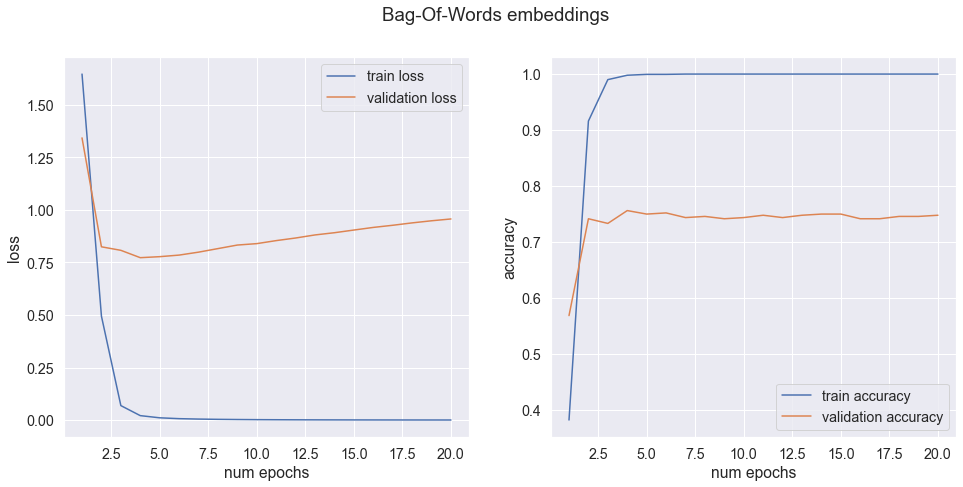

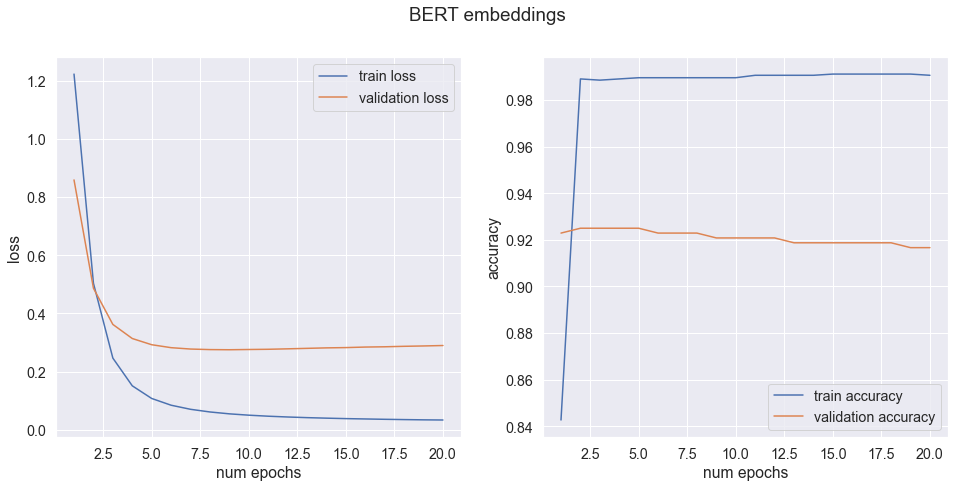

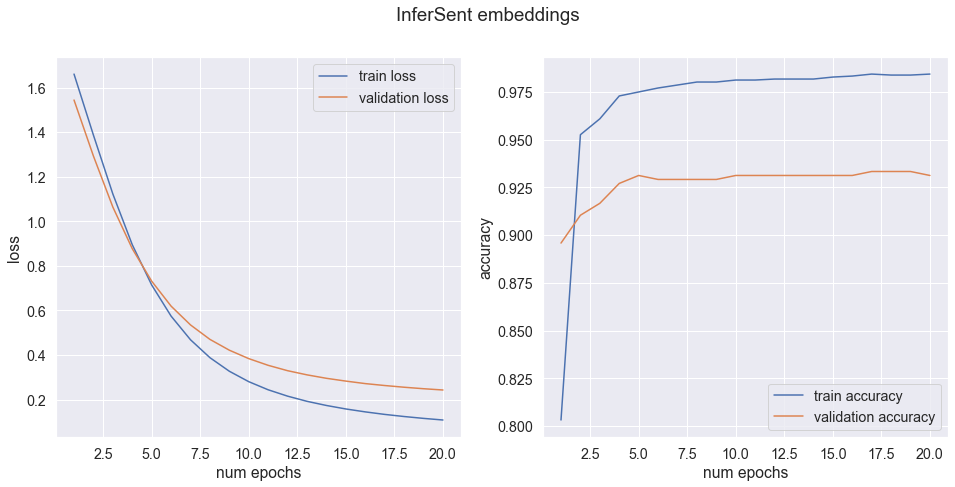

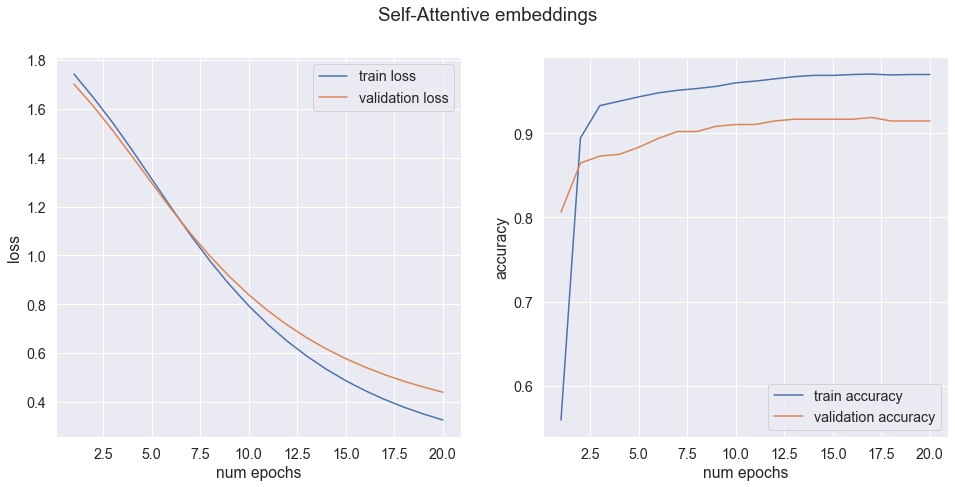

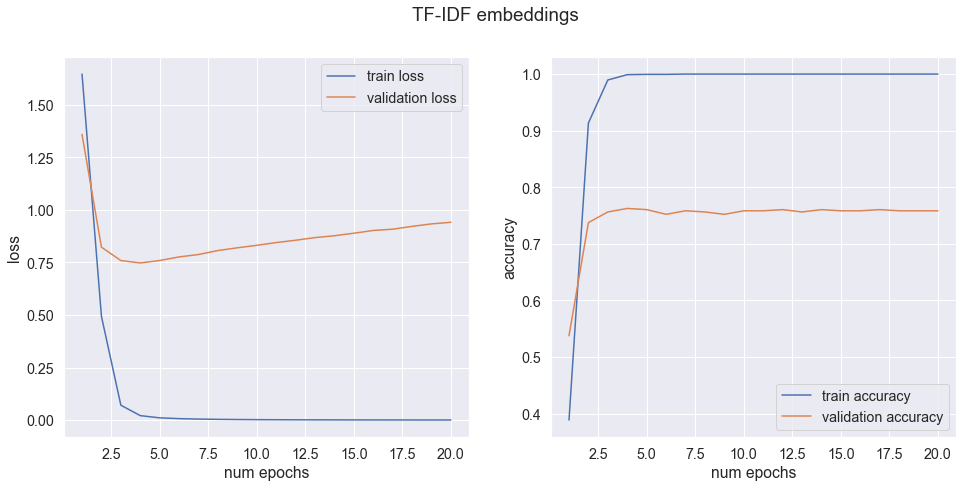

In [13]:
titles = ['Bag-Of-Words', 'BERT', 'InferSent', 'Self-Attentive', 'TF-IDF']
for title, history in zip(titles, histories):
    num_epochs = len(history['train_loss'])
    
    plt.figure(figsize=(16, 7))
    plt.suptitle(title + ' embeddings')
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(num_epochs) + 1, history['train_loss'], label='train loss')
    plt.plot(np.arange(num_epochs) + 1, history['val_loss'], label='validation loss')
    plt.xlabel('num epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(num_epochs) + 1, history['train_acc'], label='train accuracy')
    plt.plot(np.arange(num_epochs) + 1, history['val_acc'], label='validation accuracy')
    plt.xlabel('num epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [20]:
accuracies = defaultdict(list)
for path in tqdm(pathes):
    train_dataloader, val_dataloader = get_embeddings_dataloaders('./embeddings/' + path, y)
    emb_size = list(train_dataloader)[0][0].shape[1]
    emb_name = '_'.join(path.split('_')[:-1])
    
    model = ClassificationNet(emb_size, 6).to(device)
    model.load_state_dict(torch.load('./classification_weights/{}_classification.pht'.format(emb_name)))
    
    for X_val_batch, y_val_batch in val_dataloader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

        predictions = model(X_val_batch)

        target = y_val_batch.detach().cpu().numpy()
        predictions = predictions.detach().cpu().numpy().argmax(axis=1)

        accuracies[emb_name].extend((target == predictions) * 1)

  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x00000247E060DDC0>
Traceback (most recent call last):
  File "c:\users\константин\appdata\local\programs\python\python38\lib\site-packages\tqdm\std.py", line 1143, in __del__
    self.close()
  File "c:\users\константин\appdata\local\programs\python\python38\lib\site-packages\tqdm\notebook.py", line 280, in close
    self.disp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [32]:
df = pd.DataFrame(accuracies)
df.columns = titles
df.to_csv('accuracy.csv')